### Set-up:

* Для выполнения данного задания я использовал **Docker**. Для сборки образа можно воспользоваться следующей командой: `docker build -t core-ml .`
* Также, я использую GPU в контейнере. Для этого необходимо установить дополнительное расширения для Docker. 
* Для запуска контейнера я воспользовался следующей командой: `docker run -it -p 8888:8888 -v $(pwd):/app --gpus all core-ml`.

Выполнил [Елизаров Павел](https://vk.com/epepepepepepepepepepepepepepepep).

---

### Импорт необходимых библиотек

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch
import scipy
import optuna
from tqdm import tqdm

### Предобработка для работы над моделями коллаборативной фильрации:
Здесь сначала преобразуется часть исключительно для коллаборативной части

In [2]:
# Начнем с самого вкусного - с рейтингов
ratings = pd.read_csv('./data/rating.csv')
# Трансформируем в timestamp для более удобной работы
ratings['timestamp'] = pd.to_datetime(ratings['timestamp']).astype('int64') // 10**9

Следует проверить, какие фильмы просмотрели редко, а какие часто. Это позволит оставить только те фильмы, которые не будут зашумлять работу коллаборативной фильтрации. 
Для того, чтобы убрать редко-просматриваемые фильмы, воспользуемся правилом "логтя".

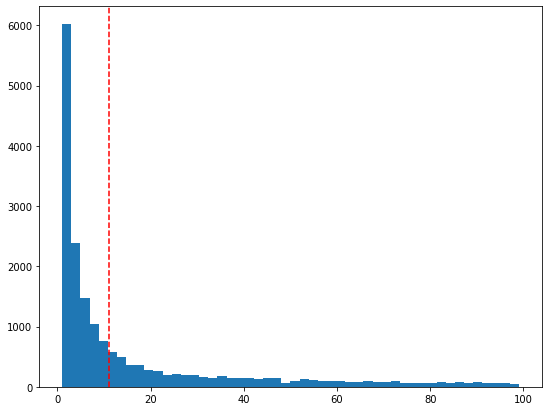

In [3]:
counts = ratings.groupby('movieId')['userId'].count()

plt.figure(figsize=(9, 7))
plt.hist(counts[counts < 100], bins=50)
# Число 11 - ложится на логоть
plt.axvline(11, color='red', linestyle='--')
plt.show()

Уберем те фильмы, которые встречаются очень редко, а именно, которые встречаются меньше 11 раз

In [4]:
ratings = ratings[ratings['movieId'].isin(counts[counts >= 11].index)]

### Разделение на тренировочную, валидационную и тестовую выборки:

* Для разделения на выборки стоит использовать критерий по времени. То есть, в тестовой и валидационной выборках должны присутствовать взаимодействия, которые произошли после взаимодействий из тренировочной выборки. Выберем 70% данных на тренировочную выборку, 10% на валидационную выборку и 20% на тест. 
* Тренировочная выбора создается для обучения моделей, валидационная - для настройки гиперпараметров, тестовая - для анализа качества модели.
* Все выборки преобразуем к sparse csr матрицам с фиксированным размером всего датасета.

In [6]:
# Переделаем индексы, чтобы было проще работать со sparse-матрицами: создадим энкодеры и декодеры в последовательные id
movie_encoder = {k: v for v, k in enumerate(np.unique(ratings['movieId']))}
user_encoder = {k: v for v, k in enumerate(np.unique(ratings['userId']))}
movie_decoder = {k: v for k, v in enumerate(np.unique(ratings['movieId']))}
user_decoder = {k: v for k, v in enumerate(np.unique(ratings['userId']))}

# Переделаем Id
ratings['movieId'] = ratings['movieId'].apply(lambda x: movie_encoder[x])
ratings['userId'] = ratings['userId'].apply(lambda x: user_encoder[x])



# Выбор трешхолдов для разделения на тренировочную, валидационную и тесовую выборки:
val_threshold, test_threshold = np.percentile(ratings['timestamp'], 70), np.percentile(ratings['timestamp'], 80)

# Разделяем датасеты:
train, train_val, validation, test = ratings[ratings['timestamp'] < val_threshold],\
                                                 ratings[ratings['timestamp'] < test_threshold],\
                                                 ratings[(ratings['timestamp'] >= val_threshold) & (ratings['timestamp'] < test_threshold)],\
                                                 ratings[ratings['timestamp'] >= test_threshold]

# Также сохраним количество уникальных пользователей и количество уникальных фильмов для созранения sparse матриц.
matrix_shape = (len(np.unique(ratings['userId'])), len(np.unique(ratings['movieId'])))

# Преобразование в sparse-матрицы
train, train_val, validation, test = sp.csr_matrix((train['rating'], (train['userId'], train['movieId'])), shape=matrix_shape),\
                                     sp.csr_matrix((train_val['rating'], (train_val['userId'], train_val['movieId'])), shape=matrix_shape),\
                                     sp.csr_matrix((validation['rating'], (validation['userId'], validation['movieId'])), shape=matrix_shape),\
                                     sp.csr_matrix((test['rating'], (test['userId'], test['movieId'])), shape=matrix_shape)

---

### Пробуем применить только коллаборативный подход: *MostPopular-модель*, *SVD-like*, *ALS*, и *AutoEncoder*.



---

#### _Немного о метрике качества:_

Для измерения качества, я выбрал метрику ранжирования **nDCG@k**. Это метрика ранжирования, где степень релевантности задается не бинарной величиной. Так как в нашем случае релевантность задается оценкой, степень релевантности - не бинарная. 

---

Также можно использовать **MAP@k**, однако, тогда оценки придется переводить в бинарные. (Например, 1 - если оценка выше или рана 4, 0 - иначе).

#### _Немного о статистической проверке:_
После предсказаний для каждого пользователя, мы можем расчитать для них метрику nDCG@k. Для каждой модели будем проверять, различаются ли метрики, составленные из рекомендаций моделей, от метрик, составленных из рандомных рекомендаций с помошью t-теста. k выберем равным 20.

---

#### _Немного о настройке гиперпараметров:_
Для некоторых моделей я буду настраивать гиперпараметры с помощью Байесовского алгоритма, реализованного в библиотеке *optuna*. Также для настройки гиперпарамтров можно использовать поиск по сетке или случайный поиск. Во время настройки гиперпараметров будем ориентироваться на качество валидационной выборки.

---

In [9]:
# Импортируем модели
from src.models import MostPopular, SVDRecommender
from src.torch_models import TorchALS, AutoEncoderRecommender

# Импортируем ALS из библиотеки implicit 
from implicit.als import AlternatingLeastSquares

# Импортируем метрику
from src.utils import ndcg_at_k

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Для того, чтобы сэкономить память, проверять качество модели будем для самых активных пользователей, а именно для тех, кто всего посмотрел больше 20 фильмов, а за время тестового периода - больше 5.
То же самое сделаем для валидации.

In [10]:
test_active, train_for_test, train_val_for_test= test[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)], train[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)],\
                                                 train_val[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)]
val_active, train_for_val = validation[(train.getnnz(1) > 10) & (validation.getnnz(1) > 5)], train[(train.getnnz(1) > 10) & (validation.getnnz(1) > 5)]

### Most Popular: 
Основана на том, что берет либо самые популярные фильмы, либо лучшие по рейтингу

In [11]:
# Тренируем и смотрим на перформанс MostPopular
most_pop = MostPopular(popularity_type='by_rating')
most_pop.fit(train_val)
print("Predicting stage")
predictions = most_pop.predict(train_for_test, test_active, excluding_predictions=train_val_for_test, batch_size=100, drop_cold_users=True)

print("NDCG calculating stage")
# Считаем метрику
most_pop_ndcg = [ndcg_at_k(predictions, test_active, k=i).mean() for i in (10, 20, 50, 100)]

  3%|▎         | 1/30 [00:00<00:03,  8.77it/s]

Predicting stage


 20%|██        | 6/30 [00:00<00:00, 51.20it/s]

NDCG calculating stage


100%|██████████| 30/30 [00:00<00:00, 52.72it/s]


In [23]:
# тестируем
random_predictions = np.random.randint(0, train.shape[1], (test_active.shape[0], 20))
model_prediction = most_pop.predict(train_for_test, test_active, excluding_predictions=train_val_for_test, batch_size=100, drop_cold_users=True, number_of_predictions=20)

random_ndcg = ndcg_at_k(random_predictions, test_active, k=20)
model_ndcg = ndcg_at_k(model_prediction, test_active, k=20)

print(
f"""
P-value: {scipy.stats.ttest_ind(random_ndcg, model_ndcg)[1]}
"""
)


100%|██████████| 30/30 [00:00<00:00, 53.87it/s]


P-value: 2.7334673513478037e-307



Средние значения метрик, полученные с помощью рандомных предсказаний и с помощью предсказаний модели, статистически значимо различаются.

### SVD:
Основана на SVD-разложении

In [29]:
# Применим оптимизацию гиперпараметров
val_user_ids = np.arange(validation.shape[0])[(train.getnnz(1) > 10) & (validation.getnnz(1) > 5)]
def objective(trial):
    n_components = trial.suggest_int("n_components", 60, 100, 20)
    n_iter = trial.suggest_int("n_iter", 10, 20, 5)
    svd_rec = SVDRecommender(n_components=n_components, n_iter=n_iter)
    svd_rec.fit(train)
    predictions = svd_rec.predict(train, val_active, excluding_predictions=train, batch_size=100, drop_cold_users=True,
                             user_ids=val_user_ids)
    
    return ndcg_at_k(predictions, val_active, k=20).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

best_params = study.best_params

svd_rec = SVDRecommender(**best_params)
svd_rec.fit(train_val)
user_ids = np.arange(test.shape[0])[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)]

print("Predicting stage")
predictions = svd_rec.predict(train_val_for_test, test_active, excluding_predictions=train_val, batch_size=100, drop_cold_users=True,
                             user_ids=user_ids)

print("NDCG calculating stage")
# Считаем метрику
svd_ndcg = [ndcg_at_k(predictions, test_active, k=i).mean() for i in (10, 20, 50, 100)]

[I 2021-06-15 18:52:02,048] A new study created in memory with name: no-name-53d9ad37-23d6-4aa6-86c2-975461a1c51d
100%|██████████| 40/40 [00:00<00:00, 53.82it/s]
[I 2021-06-15 18:52:35,106] Trial 0 finished with value: 0.14369960370709534 and parameters: {'n_components': 60, 'n_iter': 20}. Best is trial 0 with value: 0.14369960370709534.
100%|██████████| 40/40 [00:00<00:00, 54.13it/s]
[I 2021-06-15 18:53:13,444] Trial 1 finished with value: 0.13727802593366245 and parameters: {'n_components': 100, 'n_iter': 15}. Best is trial 0 with value: 0.14369960370709534.
100%|██████████| 40/40 [00:00<00:00, 54.06it/s]
[I 2021-06-15 18:53:32,669] Trial 2 finished with value: 0.1440434914519713 and parameters: {'n_components': 60, 'n_iter': 10}. Best is trial 2 with value: 0.1440434914519713.


Predicting stage


 20%|██        | 6/30 [00:00<00:00, 53.46it/s]

NDCG calculating stage


100%|██████████| 30/30 [00:00<00:00, 51.34it/s]


In [31]:
# тестируем
random_predictions = np.random.randint(0, train.shape[1], (test_active.shape[0], 20))
model_prediction = svd_rec.predict(train_for_test, test_active, excluding_predictions=train_val, batch_size=100, drop_cold_users=True, number_of_predictions=20)

random_ndcg = ndcg_at_k(random_predictions, test_active, k=20)
model_ndcg = ndcg_at_k(model_prediction, test_active, k=20)

print(
f"""
P-value: {scipy.stats.ttest_ind(random_ndcg, model_ndcg)[1]}
"""
)

100%|██████████| 30/30 [00:00<00:00, 52.72it/s]


P-value: 4.985374417909302e-70



Средние значения метрик, полученные с помощью рандомных предсказаний и с помощью предсказаний модели, статистически значимо различаются.

### ALS from Implicit
Готовая реализация ALS модели из библиотеки `implicit`.

In [34]:
# Применим оптимизацию гиперпараметров
val_user_ids = np.arange(validation.shape[0])[(train.getnnz(1) > 10) & (validation.getnnz(1) > 5)]
def objective(trial):
    factors = trial.suggest_int("factors", 64, 128, 32)
    regularization = trial.suggest_uniform("regularization", 0.01, 0.1)
    implicit_als = AlternatingLeastSquares(factors=factors, iterations=15, regularization=regularization)
    implicit_als.fit(train.transpose(), show_progress=False)
    predictions = [np.array(list(map(lambda x: x[0], implicit_als.recommend(i, train, N=20)))) for i in val_user_ids]
    predictions = np.vstack(predictions)
    
    return ndcg_at_k(predictions, val_active, k=20).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

best_params = study.best_params

implicit_als = AlternatingLeastSquares(**best_params)

user_ids = np.arange(test.shape[0])[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)]

# Требует матрицу Items X Users, поэтому транспонируем
implicit_als.fit(train_val.transpose(), show_progress=False)

print("Predicting stage")
predictions = [np.array(list(map(lambda x: x[0], implicit_als.recommend(i, train_val, N=100)))) for i in user_ids]
predictions = np.vstack(predictions)

print("NDCG calculating stage")
als_ndcg = [ndcg_at_k(predictions, test_active, k=i).mean() for i in (10, 20, 50, 100)]

[I 2021-06-15 19:01:44,339] A new study created in memory with name: no-name-7d6732e8-90b5-4744-93ad-df6e049e044d
100%|██████████| 40/40 [00:00<00:00, 51.52it/s]
[I 2021-06-15 19:06:16,355] Trial 0 finished with value: 0.12725308503421712 and parameters: {'factors': 96, 'regularization': 0.028040860432144155}. Best is trial 0 with value: 0.12725308503421712.
100%|██████████| 40/40 [00:00<00:00, 53.88it/s]
[I 2021-06-15 19:10:51,161] Trial 1 finished with value: 0.12784483950784314 and parameters: {'factors': 96, 'regularization': 0.07964901878594345}. Best is trial 1 with value: 0.12784483950784314.
100%|██████████| 40/40 [00:00<00:00, 53.01it/s]
[I 2021-06-15 19:15:34,883] Trial 2 finished with value: 0.12271271133956951 and parameters: {'factors': 128, 'regularization': 0.015277866847984291}. Best is trial 1 with value: 0.12784483950784314.


Predicting stage


 20%|██        | 6/30 [00:00<00:00, 52.07it/s]

NDCG calculating stage


100%|██████████| 30/30 [00:00<00:00, 52.17it/s]


In [38]:
# тестируем
random_predictions = np.random.randint(0, train.shape[1], (test_active.shape[0], 20))
model_prediction = [np.array(list(map(lambda x: x[0], implicit_als.recommend(i, train_val, N=100)))) for i in user_ids]
model_prediction = np.vstack(model_prediction)

random_ndcg = ndcg_at_k(random_predictions, test_active, k=20)
model_ndcg = ndcg_at_k(model_prediction, test_active, k=20)

print(
f"""
P-value: {scipy.stats.ttest_ind(random_ndcg, model_ndcg)[1]}
"""
)

100%|██████████| 30/30 [00:00<00:00, 52.71it/s]


P-value: 0.0



Средние значения метрик, полученные с помощью рандомных предсказаний и с помощью предсказаний модели, статистически значимо различаются.

### Torch ALS
Попробовал реализовать собственную версию ALS на PyTorch. Гиперпараметры оставлю с прошлой модели

In [44]:
torch_als = TorchALS(n_factors=best_params["factors"], regularization=best_params["regularization"], 
                    n_iterations=15, device=device)
user_ids = np.arange(test.shape[0])[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)]
torch_als.fit(train_val)


print("Predicting stage")
predictions = torch_als.predict(train_val_for_test, test_active, excluding_predictions=train_val, batch_size=100, drop_cold_users=True,
                                 user_ids=user_ids)

print("NDCG calculating stage")
torch_als_ndcg = [ndcg_at_k(predictions, test_active, k=i).mean() for i in (10, 20, 50, 100)]

100%|██████████| 15/15 [03:54<00:00, 15.61s/it]


Predicting stage


 20%|██        | 6/30 [00:00<00:00, 53.57it/s]

NDCG calculating stage


100%|██████████| 30/30 [00:00<00:00, 52.48it/s]


In [45]:
# тестируем
random_predictions = np.random.randint(0, train.shape[1], (test_active.shape[0], 20))
model_prediction = torch_als.predict(train_for_test, test_active, excluding_predictions=train_val, batch_size=100, drop_cold_users=True, number_of_predictions=20)

random_ndcg = ndcg_at_k(random_predictions, test_active, k=20)
model_ndcg = ndcg_at_k(model_prediction, test_active, k=20)

print(
f"""
P-value: {scipy.stats.ttest_ind(random_ndcg, model_ndcg)[1]}
"""
)

100%|██████████| 30/30 [00:00<00:00, 53.90it/s]


P-value: 3.910802885944211e-96



Средние значения метрик, полученные с помощью рандомных предсказаний и с помощью предсказаний модели, статистически значимо различаются.

### AutoEncoder
Это один из видов нейросетевых рекомендаций. Также постарался реализовать эту модель на pytorch. Здесь также можно затюнить гиперпараметры, однако, это куда затруднительнее с точки зрения вычислений. 

In [46]:
from src.torch_models import AutoEncoderRecommender

val_user_ids = np.arange(validation.shape[0])[(train.getnnz(1) > 10) & (validation.getnnz(1) > 5)]

autoencoder = AutoEncoderRecommender(n_items=train.shape[1],
                                    layers_dims=[1024, 1024, 1024, 1024, 1024*2],
                                    activation='relu',
                                    n_epoch=10,
                                    device=device,
                                    lr=0.005,
                                    optimizer='adam',
                                    batch_size=256,
                                    dropout=0.8,
                                    augmentation_step=1)

autoencoder.to(device)
autoencoder.train()
autoencoder.fit(train, val_active, val_user_ids=val_user_ids)

Epoch 2:   1%|          | 2/394 [00:00<00:27, 14.44it/s, Train Loss: 451.72375]

Validation NDCG: 0.09756645925484847


Epoch 3:   1%|          | 2/394 [00:00<00:31, 12.61it/s, Train Loss: 288.17816]

Validation NDCG: 0.09610678633310907


Epoch 4:   1%|          | 2/394 [00:00<00:28, 13.75it/s, Train Loss: 177.11029]

Validation NDCG: 0.09534182404242565


Epoch 5:   1%|          | 2/394 [00:00<00:29, 13.30it/s, Train Loss: 576.61267]

Validation NDCG: 0.09497657825057172


Epoch 6:   1%|          | 2/394 [00:00<00:26, 14.73it/s, Train Loss: 200.18311]

Validation NDCG: 0.10686153243773526


Epoch 7:   1%|          | 2/394 [00:00<00:28, 13.86it/s, Train Loss: 367.56152]

Validation NDCG: 0.10430074535726323


Epoch 8:   1%|          | 2/394 [00:00<00:25, 15.26it/s, Train Loss: 477.42065]

Validation NDCG: 0.10293957990836208


Epoch 9:   1%|          | 2/394 [00:00<00:25, 15.15it/s, Train Loss: 256.99323]

Validation NDCG: 0.10418713374798778


Epoch 10:   1%|          | 2/394 [00:00<00:28, 13.55it/s, Train Loss: 321.17081]

Validation NDCG: 0.10566184081223955


100%|██████████| 40/40 [00:00<00:00, 52.53it/s]

Validation NDCG: 0.10289168636471452


In [47]:
torch.cuda.empty_cache()

In [48]:
autoencoder.eval()
# autoencoder.load_state_dict(autoencoder.best_params)
user_ids = np.arange(test.shape[0])[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)]
predictions = autoencoder.predict(train_val, test_active, excluding_predictions=train_val, batch_size=100, drop_cold_users=True,
                             user_ids=user_ids)

autoencoder_ndcg = [ndcg_at_k(predictions, test_active, k=i).mean() for i in (10, 20, 50, 100)]

100%|██████████| 30/30 [00:00<00:00, 52.41it/s]


In [49]:
# тестируем
random_predictions = np.random.randint(0, train.shape[1], (test_active.shape[0], 20))
model_prediction = autoencoder.predict(train_val, test_active, excluding_predictions=train_val, batch_size=100, drop_cold_users=True,
                             user_ids=user_ids, number_of_predictions=20)

random_ndcg = ndcg_at_k(random_predictions, test_active, k=20)
model_ndcg = ndcg_at_k(model_prediction, test_active, k=20)

print(
f"""
P-value: {scipy.stats.ttest_ind(random_ndcg, model_ndcg)[1]}
"""
)

100%|██████████| 30/30 [00:00<00:00, 53.74it/s]


P-value: 4.0536048234926105e-277



Средние значения метрик, полученные с помощью рандомных предсказаний и с помощью предсказаний модели, статистически значимо различаются.

### Сравнение моделей

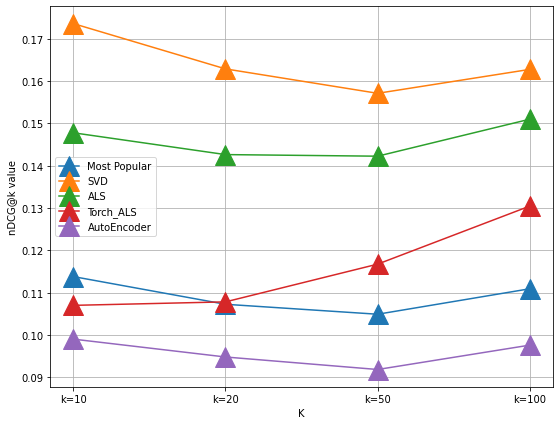

In [50]:
fig, ax = plt.subplots(figsize=(9,7))
x = np.arange(0, 4)
ax.plot(x, most_pop_ndcg, marker='^', markersize=20, label='Most Popular')
ax.plot(x, svd_ndcg, marker='^', markersize=20, label='SVD')
ax.plot(x, als_ndcg, marker='^', markersize=20, label='ALS')
ax.plot(x, torch_als_ndcg, marker='^', markersize=20, label='Torch_ALS')#
ax.plot(x, autoencoder_ndcg, marker='^', markersize=20, label='AutoEncoder')
ax.legend()
ax.set_xticks(x)
labels = [f"k={i}" for i in (10, 20, 50, 100)]
ax.set_xticklabels(labels)
ax.set_xlabel("K")
ax.set_ylabel("nDCG@k value")
ax.grid()
plt.show()

Лучше всего себя показали SVD и ALS модели. AutoEncoder не обошел даже MostPopular модель. Однако, так как AutoEncoder имеет в себе много гиперпараметров, которые стоит настроить, а также, требует больше эпох для лучшего схождения, данный алгоритм может быть улучшен.

### Предобработка данных признаков фильмов
Преобразуем данные в матрицу признаков для фильмов.

In [51]:
# Подгрущим данные с признаками о фильмах
items_features = pd.read_csv('./data/genome_scores.csv')

# оставим только фильмы, которые присутсвуют у нас в датасете
items_features = items_features[items_features['movieId'].isin(movie_decoder.values())]

# Сделаем новые MovieID для создания Sparse Матрицы
items_features['movieId'] = items_features['movieId'].apply(lambda x: movie_encoder[x])

# id тегов тоже переделаем в нужный формат
items_features['tagId'] -= 1

# Преобразуем в csr матрицу
items_features = sp.csr_matrix((items_features['relevance'], (items_features['movieId'], items_features['tagId'])))

### LightFM

In [ ]:
from lightfm import LightFM

lf = LightFM(no_components=30)
lf.fit(train_val_for_test, item_features=items_features, epochs=10, num_threads=6)

### К сожалению, у меня очень долго обучался LightFM, и я не смог проанализировать его результаты :(

### DSSM
Попробовал реализовать DSSM на Pytorch. Гиперпараметры также не вычислялись из-за вычислительных ограничений.

In [52]:
from src.torch_models import DSSM

dssm = DSSM(user_dim=128, item_dim=items_features.shape[1], layers_dims=[1024, 512, 256],
            device=device, n_users=train.shape[0],
           batch_size=512)
dssm.to(device)

val_user_ids = np.arange(validation.shape[0])[(train.getnnz(1) > 10) & (validation.getnnz(1) > 5)]
train_user_ids = np.arange(validation.shape[0])

dssm.fit(train, val_active, item_features=items_features, user_ind_train=train_user_ids, user_ind_val=val_user_ids)

Epoch 2:   0%|          | 1/271 [00:00<00:40,  6.60it/s, Train Loss: 1.2711688608480169e+21]

Validation NDCG: 0.11031884623512832


Epoch 3:   0%|          | 1/271 [00:00<00:40,  6.72it/s, Train Loss: 4.68031524724898e+20]

Validation NDCG: 0.11024503311835472


Epoch 4:   0%|          | 1/271 [00:00<00:40,  6.70it/s, Train Loss: 3.1184654891020085e+20]

Validation NDCG: 0.1101828085707756


Epoch 5:   0%|          | 1/271 [00:00<00:41,  6.43it/s, Train Loss: 2.3318987959640785e+20]

Validation NDCG: 0.10985087122014847


Epoch 6:   0%|          | 1/271 [00:00<00:40,  6.65it/s, Train Loss: 1.018653542669353e+20]

Validation NDCG: 0.10967045870230498


Epoch 7:   0%|          | 1/271 [00:00<00:43,  6.17it/s, Train Loss: 9.048380803052365e+19]

Validation NDCG: 0.10945030345322956


Epoch 8:   0%|          | 1/271 [00:00<00:42,  6.37it/s, Train Loss: 6.5822804556531106e+19]

Validation NDCG: 0.10954587769080419


Epoch 9:   0%|          | 1/271 [00:00<00:41,  6.55it/s, Train Loss: 4.672342556494581e+19]

Validation NDCG: 0.10951990177118412


Epoch 10:   0%|          | 1/271 [00:00<00:41,  6.46it/s, Train Loss: 4.753336981043072e+19]

Validation NDCG: 0.10921261369910792


100%|██████████| 40/40 [00:00<00:00, 52.47it/s]

Validation NDCG: 0.10919725684664172


In [53]:
user_ids = np.arange(test.shape[0])[(train.getnnz(1) > 10) & (test.getnnz(1) > 5)]
predictions = dssm.predict(item_features=items_features, number_of_predictions=100, user_ids=user_ids, excluding_predictions=train_val)

In [59]:
ndcg_dssm = [ndcg_at_k(predictions, test_active, k=i).mean() for i in (10, 20, 50, 100)]

100%|██████████| 30/30 [00:00<00:00, 51.71it/s]


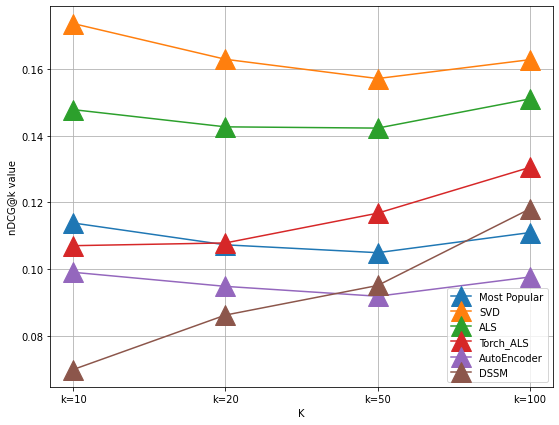

In [60]:
fig, ax = plt.subplots(figsize=(9,7))
x = np.arange(0, 4)
ax.plot(x, most_pop_ndcg, marker='^', markersize=20, label='Most Popular')
ax.plot(x, svd_ndcg, marker='^', markersize=20, label='SVD')
ax.plot(x, als_ndcg, marker='^', markersize=20, label='ALS')
ax.plot(x, torch_als_ndcg, marker='^', markersize=20, label='Torch_ALS')#
ax.plot(x, autoencoder_ndcg, marker='^', markersize=20, label='AutoEncoder')
ax.plot(x, ndcg_dssm, marker='^', markersize=20, label='DSSM')
ax.legend()
ax.set_xticks(x)
labels = [f"k={i}" for i in (10, 20, 50, 100)]
ax.set_xticklabels(labels)
ax.set_xlabel("K")
ax.set_ylabel("nDCG@k value")
ax.grid()
plt.show()

DSSM также может быть улучшена путем более тщательной настройки гиперпараметров и обучения на большем количестве эпох.

In [57]:
# тестируем
random_predictions = np.random.randint(0, train.shape[1], (test_active.shape[0], 20))
model_prediction = dssm.predict(item_features=items_features, number_of_predictions=20, user_ids=user_ids, excluding_predictions=train_val,)

random_ndcg = ndcg_at_k(random_predictions, test_active, k=20)
model_ndcg = ndcg_at_k(model_prediction, test_active, k=20)

print(
f"""
P-value: {scipy.stats.ttest_ind(random_ndcg, model_ndcg)[1]}
"""
)

100%|██████████| 30/30 [00:00<00:00, 53.97it/s]


P-value: 0.0



Средние значения метрик, полученные с помощью рандомных предсказаний и с помощью предсказаний модели, статистически значимо различаются.

---

### Что можно еще было бы реализовать:
* По моделям, использующим только коллаборативный подход: Использовать модели, основанные на других разложениях (SVD++, Factorization Machines, DeepMF, ...)
* По моделям, испольпользующим колабборативный и контентный подходы: Развивать идею DSSM, использовать другие модели, основанные на параллельных сетях (Например, CoNet)
* По данным: Преобразовать оценки в бинарные признаки, или какие-то другие, где также можно высчитать позитивный негативный фидбэк. Также использовать другие лоссы и метрики.
* По статистической проверке: Можно посчитать доверительные интервалы для метрик nDCG с помощью bootsrap-выборок без возвращения, чтобы посмотреть, как они изменяются при увеличении K (как изменяется размер интервала, повторяет ли он динамику основной величины)
* Также стоит в иных кейсах тюнить гиперпараметры всех моделей. Отдельно обрабатывать холодных пользователей и холодные айтемы.